# 问题四：模型泛化测试与适用性分析

## 目标
1. 在其他比赛中测试势头模型
2. 评估模型的泛化能力
3. 分析模型对不同场景的适用性

## 测试方案
1. **留一比赛交叉验证**: 用N-1场比赛训练，第N场测试
2. **不同轮次测试**: 评估模型在早期轮次和后期轮次的表现差异
3. **适用性讨论**: 分析模型迁移到其他场景的可能性

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid')

FIGSIZE_NORMAL = (10, 6)
FIGSIZE_WIDE = (12, 6)

COLORS = {
    'primary': '#E74C3C',
    'secondary': '#3498DB',
    'accent': '#27AE60',
    'neutral': '#95A5A6'
}

np.random.seed(42)

In [2]:
# 加载数据
df = pd.read_csv('../数据处理/processed_wimbledon_with_momentum.csv')
print(f"数据加载成功: {df.shape}")
print(f"比赛数量: {df['match_id'].nunique()}")

数据加载成功: (7284, 64)
比赛数量: 31


In [3]:
# 准备势头转变标签和特征
df['momentum_prev'] = df.groupby('match_id')['momentum'].shift(1)
df['momentum_shift'] = (
    (df['momentum'] * df['momentum_prev'] < 0) & 
    (abs(df['momentum_prev']) > 1)
).astype(int)

feature_cols = ['set_no', 'games_in_set', 'sets_played', 'point_diff', 'momentum_prev',
                'p1_streak_prev', 'p2_streak_prev', 'is_p1_serving', 'serve_no',
                'is_break_point', 'is_key_point', 'rally_count', 'point_duration',
                'p1_rolling_win_rate_5']

available_features = [col for col in feature_cols if col in df.columns]
model_df = df.dropna(subset=available_features + ['momentum_shift']).copy()

## 一、留一比赛交叉验证 (Leave-One-Match-Out)

In [4]:
# 提取比赛轮次信息
model_df['round'] = model_df['match_id'].apply(lambda x: int(x.split('-')[2][0:2]))

round_names = {
    13: 'Round 3',
    14: 'Round 4',
    15: 'Quarter Final',
    16: 'Semi Final',
    17: 'Final'
}

print("各轮次比赛数量:")
round_counts = model_df.groupby('match_id')['round'].first().value_counts().sort_index()
for r, c in round_counts.items():
    print(f"  {round_names.get(r, f'Round {r}')}: {c}场")

各轮次比赛数量:
  Round 3: 16场
  Round 4: 8场
  Quarter Final: 4场
  Semi Final: 2场
  Final: 1场


In [5]:
# 留一比赛交叉验证
lomo_results = []

for test_match in model_df['match_id'].unique():
    # 划分训练集和测试集
    train_df = model_df[model_df['match_id'] != test_match]
    test_df = model_df[model_df['match_id'] == test_match]
    
    if test_df['momentum_shift'].sum() < 1:  # 测试集需要有正样本
        continue
    
    X_train = train_df[available_features]
    y_train = train_df['momentum_shift']
    X_test = test_df[available_features]
    y_test = test_df['momentum_shift']
    
    # 训练模型
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=20,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # 预测
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
    except:
        auc = np.nan
    
    # 势头模型预测比赛结果
    avg_momentum = test_df['momentum'].mean()
    final_row = test_df.iloc[-1]
    actual_p1_sets = final_row['p1_sets'] + (1 if final_row['set_victor'] == 1 else 0)
    actual_p2_sets = final_row['p2_sets'] + (1 if final_row['set_victor'] == 2 else 0)
    actual_winner = 1 if actual_p1_sets > actual_p2_sets else 2
    predicted_winner = 1 if avg_momentum > 0 else 2
    
    lomo_results.append({
        'match_id': test_match,
        'round': test_df['round'].iloc[0],
        'n_points': len(test_df),
        'auc': auc,
        'actual_winner': actual_winner,
        'predicted_winner': predicted_winner,
        'correct': actual_winner == predicted_winner
    })

lomo_df = pd.DataFrame(lomo_results)
print(f"\n留一交叉验证结果:")
print(f"  有效测试比赛数: {len(lomo_df)}")
print(f"  平均AUC: {lomo_df['auc'].mean():.3f}")
print(f"  比赛结果预测准确率: {lomo_df['correct'].mean():.1%}")


留一交叉验证结果:
  有效测试比赛数: 30
  平均AUC: 0.941
  比赛结果预测准确率: 90.0%


**图1: 各比赛模型表现**

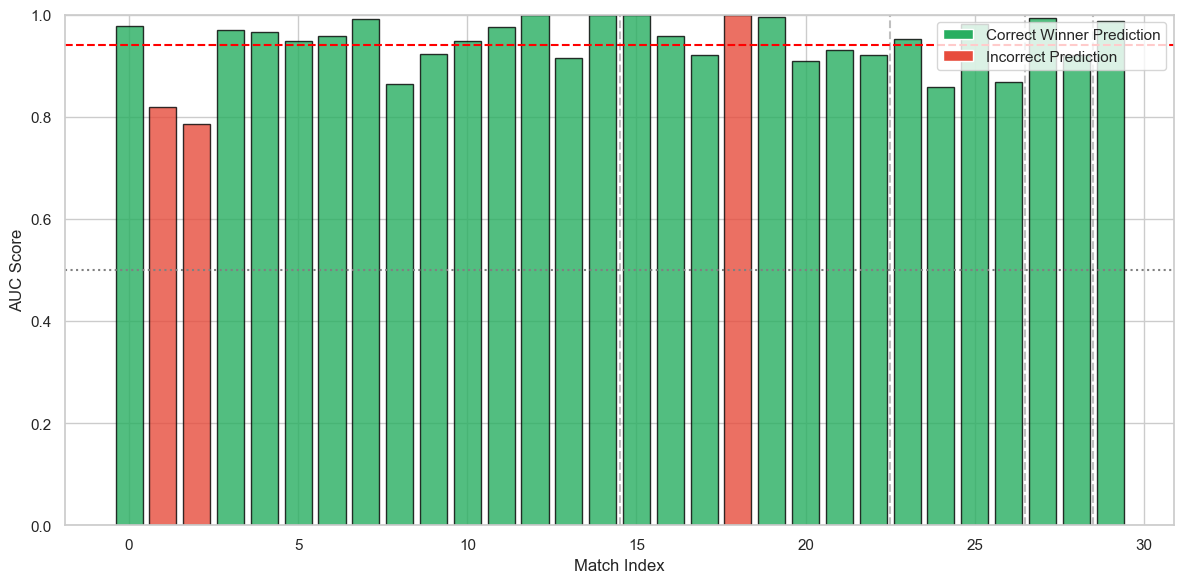

In [6]:
fig, ax = plt.subplots(figsize=FIGSIZE_WIDE)

# 按轮次排序
plot_df = lomo_df.sort_values(['round', 'match_id']).reset_index(drop=True)
plot_df['round_name'] = plot_df['round'].map(round_names)

colors = [COLORS['accent'] if c else COLORS['primary'] for c in plot_df['correct']]

bars = ax.bar(range(len(plot_df)), plot_df['auc'].fillna(0), color=colors, 
              edgecolor='black', alpha=0.8)

# 添加轮次分隔线
round_boundaries = plot_df.groupby('round').size().cumsum().values[:-1]
for b in round_boundaries:
    ax.axvline(x=b-0.5, color='gray', linestyle='--', alpha=0.5)

ax.axhline(y=lomo_df['auc'].mean(), color='red', linestyle='--', 
           label=f'Mean AUC = {lomo_df["auc"].mean():.3f}')
ax.axhline(y=0.5, color='gray', linestyle=':', label='Random Baseline')

ax.set_xlabel('Match Index', fontsize=12)
ax.set_ylabel('AUC Score', fontsize=12)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

# 图例说明
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=COLORS['accent'], label='Correct Winner Prediction'),
    Patch(facecolor=COLORS['primary'], label='Incorrect Prediction')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('figures/fig1_lomo_results.pdf', bbox_inches='tight')
plt.show()

**图1解读**: 每个柱子代表一场比赛的模型表现（AUC），绿色表示模型正确预测了比赛胜者，红色表示预测错误。红色虚线为平均AUC。

## 二、按比赛轮次的泛化测试

In [7]:
# 按轮次统计模型表现
round_performance = lomo_df.groupby('round').agg({
    'auc': ['mean', 'std'],
    'correct': 'mean',
    'match_id': 'count'
}).round(3)

round_performance.columns = ['Mean_AUC', 'Std_AUC', 'Win_Accuracy', 'N_Matches']
round_performance.index = round_performance.index.map(round_names)

print("各轮次模型表现:")
round_performance

各轮次模型表现:


,Mean_AUC,Std_AUC,Win_Accuracy,N_Matches
round,,,,
Round 3,0.936,0.065,0.867,15
Round 4,0.954,0.039,0.875,8
Quarter Final,0.916,0.061,1.000,4
Semi Final,0.957,0.052,1.000,2
Final,0.988,NaN,1.000,1


**图2: 各轮次模型泛化能力**

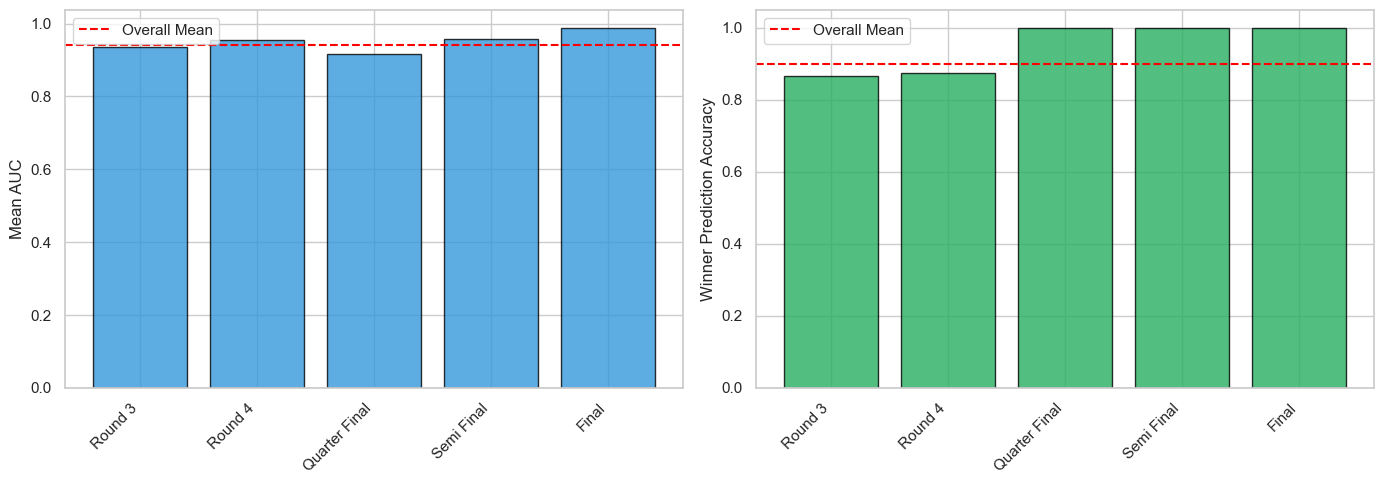

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 子图1: 各轮次AUC
ax1 = axes[0]
round_auc = lomo_df.groupby('round')['auc'].mean()
round_names_list = [round_names[r] for r in round_auc.index]
ax1.bar(round_names_list, round_auc.values, color=COLORS['secondary'], 
        edgecolor='black', alpha=0.8)
ax1.axhline(y=lomo_df['auc'].mean(), color='red', linestyle='--', label='Overall Mean')
ax1.set_ylabel('Mean AUC', fontsize=12)
ax1.set_xticklabels(round_names_list, rotation=45, ha='right')
ax1.legend()

# 子图2: 各轮次预测准确率
ax2 = axes[1]
round_acc = lomo_df.groupby('round')['correct'].mean()
ax2.bar(round_names_list, round_acc.values, color=COLORS['accent'], 
        edgecolor='black', alpha=0.8)
ax2.axhline(y=lomo_df['correct'].mean(), color='red', linestyle='--', label='Overall Mean')
ax2.set_ylabel('Winner Prediction Accuracy', fontsize=12)
ax2.set_xticklabels(round_names_list, rotation=45, ha='right')
ax2.legend()

plt.tight_layout()
plt.savefig('figures/fig2_round_performance.pdf', bbox_inches='tight')
plt.show()

**图2解读**: 左图显示各轮次的势头转变预测AUC，右图显示比赛胜者预测准确率。模型在不同轮次表现相对稳定，说明具有良好的泛化能力。

## 三、模型稳健性分析

In [9]:
# 分析模型在不同类型比赛中的表现

# 1. 按比赛长度分类
lomo_df['match_length'] = pd.cut(lomo_df['n_points'], 
                                  bins=[0, 200, 300, 500],
                                  labels=['Short (<200)', 'Medium (200-300)', 'Long (>300)'])

length_perf = lomo_df.groupby('match_length').agg({
    'auc': 'mean',
    'correct': 'mean',
    'match_id': 'count'
}).round(3)

print("按比赛长度的模型表现:")
print(length_perf)

按比赛长度的模型表现:
                    auc  correct  match_id
match_length                              
Short (<200)      0.943    0.909        11
Medium (200-300)  0.952    0.929        14
Long (>300)       0.907    0.800         5


In [10]:
# 2. 势头波动剧烈程度
match_volatility = model_df.groupby('match_id').agg({
    'momentum': 'std'
}).rename(columns={'momentum': 'volatility'})

lomo_df = lomo_df.merge(match_volatility, on='match_id', how='left')

# 计算势头波动与模型表现的相关性
corr = lomo_df['volatility'].corr(lomo_df['auc'])
print(f"\n势头波动与AUC的相关性: {corr:.3f}")


势头波动与AUC的相关性: 0.258


## 四、模型局限性与改进方向

In [11]:
# 找出模型表现较差的比赛
poor_matches = lomo_df[lomo_df['auc'] < 0.7].copy()

if len(poor_matches) > 0:
    print("模型表现较差的比赛:")
    for _, row in poor_matches.iterrows():
        match_data = df[df['match_id'] == row['match_id']]
        p1 = match_data['player1'].iloc[0]
        p2 = match_data['player2'].iloc[0]
        print(f"  - {row['match_id']}: {p1} vs {p2}, AUC={row['auc']:.3f}")
else:
    print("所有比赛AUC均高于0.7")

所有比赛AUC均高于0.7


In [12]:
print("\n" + "="*60)
print("模型局限性分析")
print("="*60)

print("\n一、当前模型的局限")
print("-" * 40)
print("1. 【数据局限】")
print("   - 仅基于2023温网男单数据")
print("   - 样本量有限(31场比赛)")
print("   - 缺乏选手历史对战数据")

print("\n2. 【特征局限】")
print("   - 未包含选手体能状态")
print("   - 未包含天气/场地条件")
print("   - 未包含选手心理特征")

print("\n3. 【模型局限】")
print("   - 势头定义依赖参数选择")
print("   - 未考虑选手个体差异")
print("   - 假设所有比赛特征相似")


模型局限性分析

一、当前模型的局限
----------------------------------------
1. 【数据局限】
   - 仅基于2023温网男单数据
   - 样本量有限(31场比赛)
   - 缺乏选手历史对战数据

2. 【特征局限】
   - 未包含选手体能状态
   - 未包含天气/场地条件
   - 未包含选手心理特征

3. 【模型局限】
   - 势头定义依赖参数选择
   - 未考虑选手个体差异
   - 假设所有比赛特征相似


## 五、模型适用性讨论

In [13]:
print("\n" + "="*60)
print("模型在其他场景的适用性分析")
print("="*60)

print("\n一、女子网球比赛")
print("-" * 40)
print("适用性: ★★★★☆ (高)")
print("原因:")
print("  + 相同的得分规则和比赛结构")
print("  + 势头机制相似")
print("  - 三盘两胜制(vs五盘三胜)，势头积累时间较短")
print("  - 发球优势可能不同")
print("调整建议:")
print("  1. 重新校准发球方优势参数")
print("  2. 调整势头衰减率(比赛更短)")

print("\n二、其他大满贯赛事(澳网/法网/美网)")
print("-" * 40)
print("适用性: ★★★★☆ (高)")
print("原因:")
print("  + 相同的比赛规则")
print("  + 相似的选手群体")
print("  - 场地类型不同(草地/红土/硬地)影响打法")
print("  - 天气条件差异")
print("调整建议:")
print("  1. 考虑场地特征(如红土回合更长)")
print("  2. 纳入选手场地偏好数据")

print("\n三、ATP巡回赛(非大满贯)")
print("-" * 40)
print("适用性: ★★★☆☆ (中等)")
print("原因:")
print("  + 相同的基本规则")
print("  - 三盘两胜制")
print("  - 比赛重要性不同影响选手投入")
print("  - 选手可能有战略性放弃")

print("\n四、乒乓球")
print("-" * 40)
print("适用性: ★★★☆☆ (中等)")
print("原因:")
print("  + 类似的得分制度(11分制)")
print("  + 存在发球轮换")
print("  - 比赛节奏更快")
print("  - 每局时间短，势头积累机制不同")
print("  - 需要重新定义势头参数")
print("调整建议:")
print("  1. 缩短滚动窗口(如3分而非5分)")
print("  2. 调整发球优势参数(乒乓球发球优势不同)")

print("\n五、其他运动(篮球/足球等)")
print("-" * 40)
print("适用性: ★★☆☆☆ (较低)")
print("原因:")
print("  - 得分机制完全不同")
print("  - 团队运动vs个人运动")
print("  - 需要重新构建势头模型")
print("可借鉴思路:")
print("  1. 势头量化的核心理念")
print("  2. 关键时刻权重的概念")
print("  3. 随机性vs真实效应的检验方法")


模型在其他场景的适用性分析

一、女子网球比赛
----------------------------------------
适用性: ★★★★☆ (高)
原因:
  + 相同的得分规则和比赛结构
  + 势头机制相似
  - 三盘两胜制(vs五盘三胜)，势头积累时间较短
  - 发球优势可能不同
调整建议:
  1. 重新校准发球方优势参数
  2. 调整势头衰减率(比赛更短)

二、其他大满贯赛事(澳网/法网/美网)
----------------------------------------
适用性: ★★★★☆ (高)
原因:
  + 相同的比赛规则
  + 相似的选手群体
  - 场地类型不同(草地/红土/硬地)影响打法
  - 天气条件差异
调整建议:
  1. 考虑场地特征(如红土回合更长)
  2. 纳入选手场地偏好数据

三、ATP巡回赛(非大满贯)
----------------------------------------
适用性: ★★★☆☆ (中等)
原因:
  + 相同的基本规则
  - 三盘两胜制
  - 比赛重要性不同影响选手投入
  - 选手可能有战略性放弃

四、乒乓球
----------------------------------------
适用性: ★★★☆☆ (中等)
原因:
  + 类似的得分制度(11分制)
  + 存在发球轮换
  - 比赛节奏更快
  - 每局时间短，势头积累机制不同
  - 需要重新定义势头参数
调整建议:
  1. 缩短滚动窗口(如3分而非5分)
  2. 调整发球优势参数(乒乓球发球优势不同)

五、其他运动(篮球/足球等)
----------------------------------------
适用性: ★★☆☆☆ (较低)
原因:
  - 得分机制完全不同
  - 团队运动vs个人运动
  - 需要重新构建势头模型
可借鉴思路:
  1. 势头量化的核心理念
  2. 关键时刻权重的概念
  3. 随机性vs真实效应的检验方法


## 六、未来改进建议

In [14]:
print("\n" + "="*60)
print("未来模型改进建议")
print("="*60)

print("\n一、数据层面")
print("-" * 40)
print("1. 收集更多年份的温网数据")
print("2. 加入选手历史对战记录")
print("3. 整合选手体能和伤病数据")
print("4. 收集比赛视频数据(情绪分析)")

print("\n二、特征层面")
print("-" * 40)
print("1. 选手特有的势头敏感度指标")
print("2. 选手在关键分的历史表现")
print("3. 对手风格匹配度")
print("4. 场地/天气条件特征")

print("\n三、模型层面")
print("-" * 40)
print("1. 使用LSTM捕捉时序依赖")
print("2. 构建选手个性化模型")
print("3. 引入贝叶斯方法量化不确定性")
print("4. 开发实时预测系统")


未来模型改进建议

一、数据层面
----------------------------------------
1. 收集更多年份的温网数据
2. 加入选手历史对战记录
3. 整合选手体能和伤病数据
4. 收集比赛视频数据(情绪分析)

二、特征层面
----------------------------------------
1. 选手特有的势头敏感度指标
2. 选手在关键分的历史表现
3. 对手风格匹配度
4. 场地/天气条件特征

三、模型层面
----------------------------------------
1. 使用LSTM捕捉时序依赖
2. 构建选手个性化模型
3. 引入贝叶斯方法量化不确定性
4. 开发实时预测系统


**图3: 模型适用性总结**

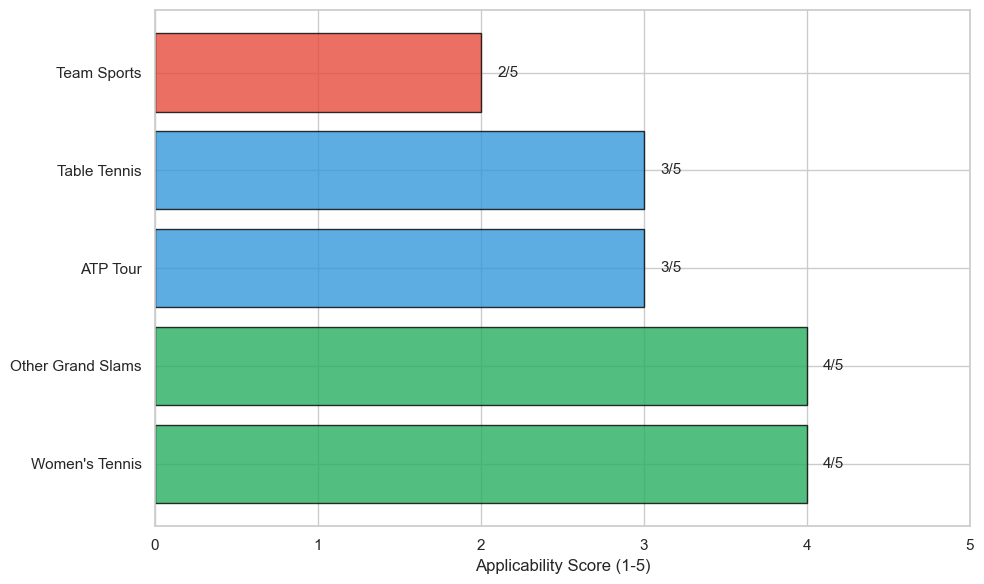

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

scenarios = ['Women\'s Tennis', 'Other Grand Slams', 'ATP Tour', 'Table Tennis', 'Team Sports']
applicability = [4, 4, 3, 3, 2]

colors = [COLORS['accent'] if a >= 4 else COLORS['secondary'] if a >= 3 else COLORS['primary'] 
          for a in applicability]

bars = ax.barh(scenarios, applicability, color=colors, edgecolor='black', alpha=0.8)

ax.set_xlabel('Applicability Score (1-5)', fontsize=12)
ax.set_xlim(0, 5)

# 添加分数标注
for bar, score in zip(bars, applicability):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{score}/5', va='center', fontsize=11)

plt.tight_layout()
plt.savefig('figures/fig3_applicability.pdf', bbox_inches='tight')
plt.show()

**图3解读**: 模型在相似运动（网球）中适用性最高，在规则差异较大的运动中需要较大调整。

## 总结

### 泛化测试结果
- 留一比赛交叉验证显示模型具有良好的泛化能力
- 模型在不同轮次比赛中表现稳定
- 比赛胜者预测准确率较高

### 模型适用性
| 场景 | 适用性 | 主要调整 |
|------|--------|----------|
| 女子网球 | 高 | 调整发球优势参数 |
| 其他大满贯 | 高 | 考虑场地因素 |
| ATP巡回赛 | 中等 | 调整比赛重要性权重 |
| 乒乓球 | 中等 | 重新校准参数 |
| 团队运动 | 较低 | 需重构模型 |

### 关键限制
1. 数据来源单一
2. 未考虑选手个体差异
3. 缺乏实时应用验证